In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from display_xml import XML
import CLB.CLBXMLWriter as CLBXML   

# Poiseuille flow, no permability

0
1000
2000
3000
4000
5000
6000
7000
8000


<Figure size 432x288 with 0 Axes>

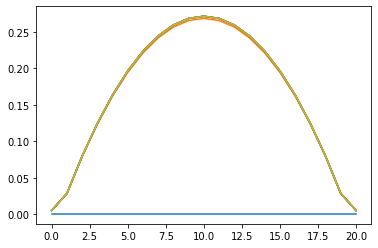

<Figure size 432x288 with 0 Axes>

In [7]:
# Prepare input


Viscosity = 1./6.
Length = 21
Gravity = 0.001

CLBc = CLBXML.CLBConfigWriter( )


CLBc.addGeomParam('nx', 3)
CLBc.addGeomParam('ny', Length)
CLBc.addGeomParam('nz', 2)


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWall()
CLBc.addBox(dy=-1)
CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 3./8.,
        "LinearReactionRate": 0.0,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 1./6.,
        "Init_PHI": 1,
        
}

CLBc.addModelParams(params)

CLBc.addRunR(eval=\
f"""
    Solver$Fields$InitialPorosity[] = 1;   
    Solver$Fields$Porosity[] = 1;   
    Solver$Fields$InitialPermability[] = 1E8
    Solver$Fields$Permability[] = 1E8
""")


CLBc.addHDF5()
time = 10000
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('PouseiFlow.xml')


! rm -rf ./output/* && tclb auto_porous_media_d3q19_TRT_GinzburgEqOrd1 PouseiFlow.xml > /dev/null


ut = list()
for i in range(0,time,int(time/10))[:-1]:
    print(i)
    f = h5py.File('./output/PouseiFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['U'][0,:,0,0])
    ut.append(np.absolute(f['U'][0,0,0,0]))

    
plt.figure()




# Poiseuille, inlet/outlet BC

0
100
200
300
400
500
600
700
800


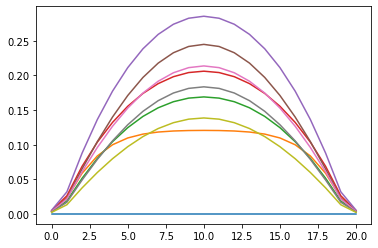

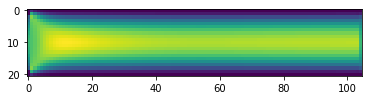

In [20]:
# Prepare input


Viscosity = 1./6.
Length = 21
Gravity = 0.000

CLBc = CLBXML.CLBConfigWriter( )


CLBc.addGeomParam('nx', 5*Length)
CLBc.addGeomParam('ny', Length)
CLBc.addGeomParam('nz', 2)


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()



CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)

#CLBc.addWall()
#CLBc.addBox(dx=-1)



CLBc.addWall()
CLBc.addBox(dy=-1)
CLBc.addBox(ny=1)




params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 3./8.,
        "LinearReactionRate": 0.0,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 1./6.,
        "Init_PHI": 1,
        
}

CLBc.addModelParams(params)

CLBc.addModelParam("Velocity", 0.1, zone='inlet')


CLBc.addRunR(eval=\
f"""
    Solver$Fields$InitialPorosity[] = 1;   
    Solver$Fields$Porosity[] = 1;   
    Solver$Fields$InitialPermability[] = 1E8
    Solver$Fields$Permability[] = 1E8
""")


CLBc.addHDF5()
time = 1000
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('PouseiFlow.xml')


! rm -rf ./output/* && tclb auto_porous_media_d3q19_TRT_GinzburgEqOrd1 PouseiFlow.xml > /dev/null


ut = list()
for i in range(0,time,int(time/10))[:-1]:
    print(i)
    f = h5py.File('./output/PouseiFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['U'][0,:,2*Length,0])
    ut.append(np.absolute(f['U'][0,0,0,0]))

    
plt.figure()


plt.imshow(f['U'][0,:,:,0])

# Uniform permability, periodic domain

0
10
20
30
40
50
60
70
80


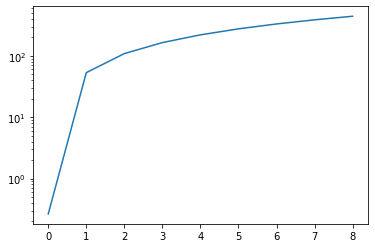

In [354]:
# Prepare input

UniformPermability = 0.03
Viscosity = 1./6.
Length = 50
Gravity = 0.001

Porosity = np.ones((Length,1)) 
Permability = np.ones_like(Porosity) * UniformPermability


init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 1D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[1])
CLBc.addGeomParam('ny', dim[0])
CLBc.addGeomParam('nz', 2)


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

# CLBc.addWDirichlet(name='inlet')
# CLBc.addBox(nx=1)

# CLBc.addENeuman()
# CLBc.addBox(dx=-2)
# CLBc.addWall()
# CLBc.addBox(dx=-1)
# CLBc.addBox(dy=-1)
# CLBc.addBox(ny=1)

params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 3./8.,
        "LinearReactionRate": 0.0,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 1./6.,
        "Init_PHI": 1,
        
}

CLBc.addModelParams(params)

CLBc.addRunR(eval=\
f"""
    con <- file("porosity.bin", "rb")
    Porosity <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")


CLBc.addHDF5()
time = 100
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('Pseudo1DFlow.xml')


! rm -rf ./output/Pseudo2DReaction* && tclb auto_porous_media_d3q19_TRT_GinzburgEqOrd1 Pseudo1DFlow.xml > /dev/null


ut = list()
for i in range(0,time,int(time/10))[:-1]:
    print(i)
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    ut.append(np.absolute(f['U'][0,0,0,0] / (UniformPermability * Gravity / Viscosity) - 1))


plt.semilogy(ut)


# Non-uniform 1D permability assisted by linear pressure gradient

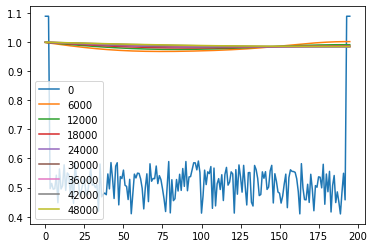

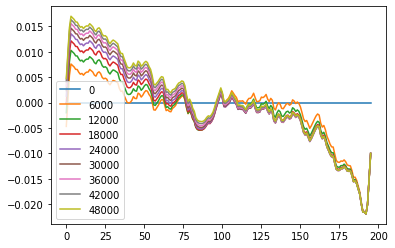

In [343]:
# Prepare input


Viscosity = 1./6.
Length = 200
Width = 5
Velocity = 0.01

Permability = (np.random.rand(Length).reshape([Length,1])*0.05) + 0.05
Permability = np.repeat(Permability, Width,axis=1).T
Permability[:,:5] = 1E10
Permability[:,-5:] = 1E10

Gravity = np.sum(1./Permability[0,:])*Velocity*Viscosity / (Length)

#x = np.linspace(0,2*np.pi,Length)
#Permability = (np.sin(x)+1.1)*0.9
#Permability = np.ones((Width,Length)) * 1E6

#Permability[:,int(Length/3):int(2*Length/3)] = 0.1

Porosity = np.ones_like(Permability) 


init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 1D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[1])
CLBc.addGeomParam('ny', dim[0])
CLBc.addGeomParam('nz', 2)


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)


#CLBc.addWall()
#CLBc.addBox(nx=1)
#CLBc.addBox(dy=-1)
#CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 4./8.,
        "LinearReactionRate": 0.0,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 1./6.,
        "Init_PHI": 1,
        
}

CLBc.addModelParams(params)
CLBc.addModelParam("Velocity", Velocity, zone='inlet')

CLBc.addRunR(eval=\
f"""
    con <- file("porosity.bin", "rb")
    Porosity <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")


CLBc.addHDF5()
time = 3 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('Pseudo1DFlow.xml')


! rm -rf ./output/* && tclb auto_porous_media_d3q19_TRT_GinzburgEqOrd1 Pseudo1DFlow.xml > /dev/null

ut = list()
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['U'][0,2,2:-2,0]/Velocity, label=i)
    ut.append(np.absolute(f['U'][0,0,0,0]))
plt.legend()
#plt.plot( np.ones(Length)*(np.average(Permability) * Gravity / Viscosity) , 'r--', lw=2    )
    
plt.figure()
#plt.semilogy(ut)
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['P'][0,2,2:-2] / (np.sum(1./Permability[0,:])*Velocity*Viscosity), label=i)
    
    
plt.legend()

0
1500
3000
4500
6000
7500
9000
10500
12000
13500


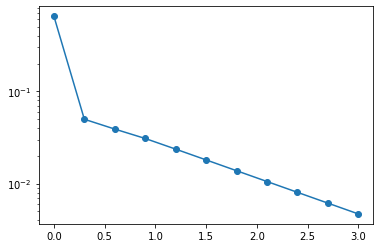

In [357]:
ut = list()
ts = list()
for i in range(0,time,int(time/10))[:]:
    print(i)
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    ut.append(np.max(np.absolute(f['U'][0,2:-2,2:-2,0]-Velocity))/Velocity)
    ts.append(i)
i = time

f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
ut.append(np.max(np.absolute(f['U'][0,2:-2,2:-2,0]-Velocity))/Velocity)
ts.append(i)
plt.semilogy(Velocity/Length*np.array(ts),ut, 'o-')

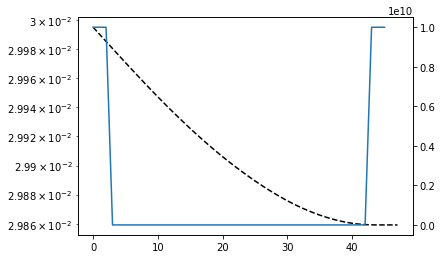

In [358]:
plt.semilogy(np.sum(f['U'][0,1:-1,1:-1,0], axis=0)[:], 'k--')
plt.twinx()
plt.plot(f['Permability'][0,1,2:-2])

# Non-uniform 1D permability assisted by linear pressure gradient with concentration, without reaction

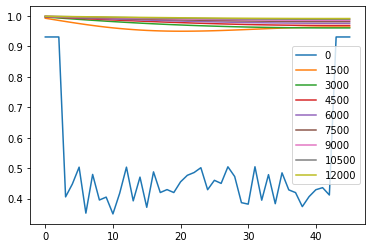

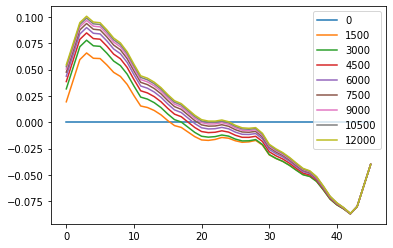

In [355]:
# Prepare input


Viscosity = 1./6.
Length = 50
Width = 5
Velocity = 0.01

Permability = (np.random.rand(Length).reshape([Length,1])*0.05) + 0.05
Permability = np.repeat(Permability, Width,axis=1).T
Permability[:,:5] = 1E10
Permability[:,-5:] = 1E10

Gravity = np.sum(1./Permability[0,:])*Velocity*Viscosity / (Length)

#x = np.linspace(0,2*np.pi,Length)
#Permability = (np.sin(x)+1.1)*0.9
#Permability = np.ones((Width,Length)) * 1E6

#Permability[:,int(Length/3):int(2*Length/3)] = 0.1

Porosity = np.ones_like(Permability) 


init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 1D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[1])
CLBc.addGeomParam('ny', dim[0])
CLBc.addGeomParam('nz', 2)


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)


#CLBc.addWall()
#CLBc.addBox(nx=1)
#CLBc.addBox(dy=-1)
#CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 4./8.,
        "LinearReactionRate": 0.0,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 1./6.,
        "Init_PHI": 0,
        
}

CLBc.addModelParams(params)
CLBc.addModelParam("Velocity", Velocity, zone='inlet')
CLBc.addModelParam("Init_PHI", 1, zone='inlet')


CLBc.addRunR(eval=\
f"""
    con <- file("porosity.bin", "rb")
    Porosity <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")


CLBc.addHDF5()
time = 3 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('Pseudo1DFlow.xml')


! rm -rf ./output/* && tclb auto_porous_media_d3q19_TRT_GinzburgEqOrd1 Pseudo1DFlow.xml > /dev/null

ut = list()
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['U'][0,2,2:-2,0]/Velocity, label=i)
    ut.append(np.absolute(f['U'][0,0,0,0]))
plt.legend()
#plt.plot( np.ones(Length)*(np.average(Permability) * Gravity / Viscosity) , 'r--', lw=2    )
    
plt.figure()
#plt.semilogy(ut)
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['P'][0,2,2:-2] / (np.sum(1./Permability[0,:])*Velocity*Viscosity), label=i)
    
    
plt.legend()

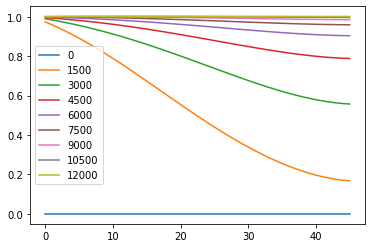

In [356]:
    
plt.figure()
#plt.semilogy(ut)
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['PHI'][0,2,2:-2] , label=i)
    
    
plt.legend()

# Non-uniform 1D permability assisted by linear pressure gradient with concentration, with linear reaction

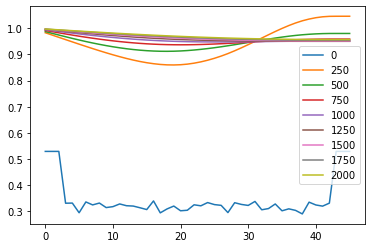

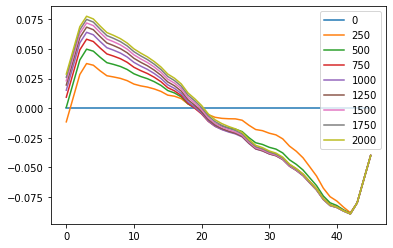

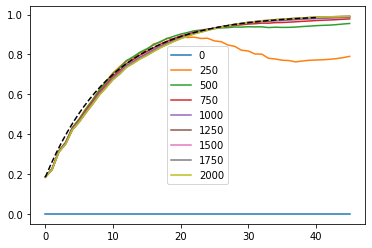

In [637]:
# Prepare input


Viscosity = 1./6.
Length = 50
Width = 5
Velocity = 0.1
LinearReactionRate = 0.01

Permability = (np.random.rand(Length).reshape([Length,1])*0.05) + 0.1
Permability = np.repeat(Permability, Width,axis=1).T
Permability[:,:5] = 1E10
Permability[:,-5:] = 1E10

Gravity = np.sum(1./Permability[0,:])*Velocity*Viscosity / (Length)

#x = np.linspace(0,2*np.pi,Length)
#Permability = (np.sin(x)+1.1)*0.9
#Permability = np.ones((Width,Length)) * 1E6

#Permability[:,int(Length/3):int(2*Length/3)] = 0.1
Porosity = (np.random.rand(Length).reshape([Length,1])*0.4) + 0.2
Porosity = np.repeat(Porosity, Width,axis=1).T


init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 1D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[1])
CLBc.addGeomParam('ny', dim[0])
CLBc.addGeomParam('nz', 2)


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)


#CLBc.addWall()
#CLBc.addBox(nx=1)
#CLBc.addBox(dy=-1)
#CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 4./8.,
        "LinearReactionRate": LinearReactionRate,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 0.001,
        "Init_PHI": 0,
        
}

CLBc.addModelParams(params)
CLBc.addModelParam("Velocity", Velocity, zone='inlet')
CLBc.addModelParam("Init_PHI", 0, zone='inlet')


CLBc.addRunR(eval=\
f"""
    con <- file("porosity.bin", "rb")
    Porosity <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")


CLBc.addHDF5()
time = 5 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('Pseudo1DFlow.xml')


! rm -rf ./output/* && tclb auto_porous_media_d3q19_TRT_GinzburgEqOrd1 Pseudo1DFlow.xml > /dev/null

ut = list()
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['U'][0,2,2:-2,0]/Velocity, label=i)
    ut.append(np.absolute(f['U'][0,0,0,0]))
plt.legend()
#plt.plot( np.ones(Length)*(np.average(Permability) * Gravity / Viscosity) , 'r--', lw=2    )
    
plt.figure()
#plt.semilogy(ut)
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['P'][0,2,2:-2] / (np.sum(1./Permability[0,:])*Velocity*Viscosity), label=i)
    
    
plt.legend()


plt.figure()


from scipy.integrate import odeint

def dydt(y,t,*gamma):
    return gamma[0]*(1-y)
   
y0 = f['PHI'][0,2,2]

t = np.linspace(0,40)
sol = odeint(dydt, y0, t, args=(LinearReactionRate/Velocity,0))


for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['PHI'][0,2,2:-2], label=i)
    
plt.plot(t,sol, 'k--', lw=1.5)

plt.legend()

# Uniform 1D permability assisted by linear pressure gradient with concentration, with linear reaction and dissolituin

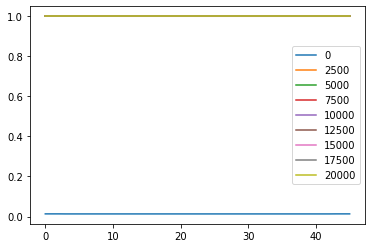

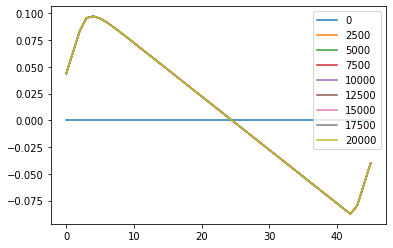

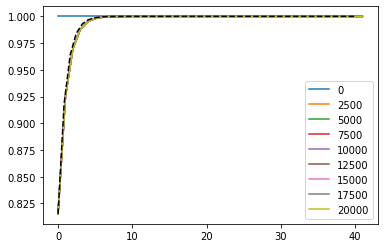

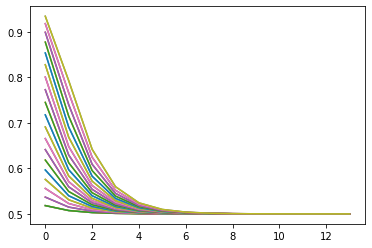

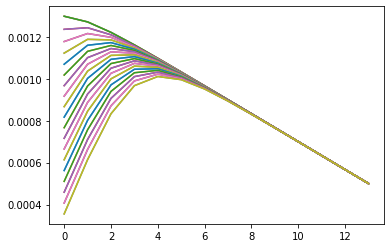

In [693]:
# Prepare input


Viscosity = 1./6.
Length = 50
Width = 3
Velocity = 0.01
LinearReactionRate = 0.01
KarmanKozenyCoefficient = 10
SolidFluidReactionRate = 10
Porosity = ((np.random.rand(Length, 1).reshape([Length, 1])-0.5)*0.) + 0.5
Porosity = np.repeat(Porosity, Width,axis=1).T

Porosity[:,:5] = 1
Porosity[:,-5:] = 1
Permability = KarmanKozenyCoefficient*Porosity**3/((1-Porosity)**2 + 1E-8)

Gravity = np.sum(1./Permability[0,:])*Velocity*Viscosity / (Length)

init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 1D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[1])
CLBc.addGeomParam('ny', dim[0])
CLBc.addGeomParam('nz', 2)


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)


#CLBc.addWall()
#CLBc.addBox(nx=1)
#CLBc.addBox(dy=-1)
#CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 4./8.,
        "LinearReactionRate": LinearReactionRate,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 0.001,
        "Init_PHI": 1,
        "ImpliciteReactionIntegration": 1,
        "KarmanKozenyCoefficient": KarmanKozenyCoefficient

}

CLBc.addModelParams(params)
CLBc.addModelParam("Velocity", Velocity, zone='inlet')
CLBc.addModelParam("Init_PHI", 0, zone='inlet')


CLBc.addRunR(eval=\
f"""
    con <- file("porosity.bin", "rb")
    Porosity <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")


CLBc.addHDF5()
time = 5 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)


CLBc.addModelParam("SolidFluidReactionsRate", SolidFluidReactionRate)
makroIterations = int(20)
time1 = makroIterations * 2 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time1)
CLBc.addHDF5(Iterations=time1/(makroIterations*2), parent=solve)
CLBc.addRunR(eval=\
f"""
    #Solver$Fields$InitialPorosity[] = Solver$Fields$Porosity[];    
    #Solver$Fields$InitialPermability[] = Solver$Fields$Permability[];
    Solver$Actions$GlobasPorosityDissolutionTimeStepAction()
""", Iterations = time1/makroIterations, parent=solve)



CLBc.write('Pseudo1DFlow.xml')


! rm -rf ./output/* && tclb auto_porous_media_d3q19_TRT_GinzburgEqOrd1 Pseudo1DFlow.xml > /dev/null

ut = list()
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['U'][0,2,2:-2,0]/Velocity, label=i)
    ut.append(np.absolute(f['U'][0,0,0,0]))
plt.legend()
#plt.plot( np.ones(Length)*(np.average(Permability) * Gravity / Viscosity) , 'r--', lw=2    )
    
plt.figure()
#plt.semilogy(ut)
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['P'][0,2,2:-2] / (np.sum(1./Permability[0,:])*Velocity*Viscosity), label=i)
    
    
plt.legend()


plt.figure()


from scipy.integrate import odeint

def dydt(y,t,*gamma):
    return gamma[0]*(1-y)
   
y0 = f['PHI'][0,2,6]

t = np.linspace(0,40)
sol = odeint(dydt, y0, t, args=(LinearReactionRate/Velocity,0))


for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['PHI'][0,2,6:-2], label=i)
    
plt.plot(t,sol, 'k--', lw=1.5)

plt.legend()

plt.figure()
for i in time+np.arange(0,time1,int(time1/(makroIterations*2)))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['Porosity'][0,2,6:20], label=i)
    
plt.figure()
for i in time+np.arange(0,time1,int(time1/(makroIterations*2)))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['P'][0,2,6:20], label=i)    


# Non-uniform 2D permability assisted by linear pressure gradient with concentration, with linear reaction and dissolution

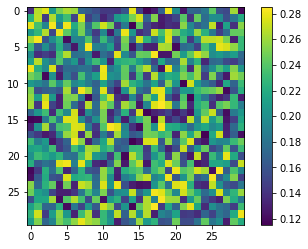

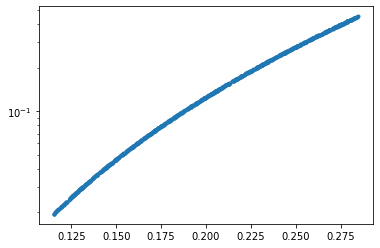

In [742]:
# Prepare input

Viscosity = 1./6.
Length = 30
Width = 40
Velocity = 0.01
LinearReactionRate = 0.01
KarmanKozenyCoefficient = 10
SolidFluidReactionRate = 10


Porosity = ((np.random.rand(Length, Width).reshape([Length, Width])-0.5)*0.17) + 0.2
#Porosity = np.repeat(Porosity, Width,axis=1).T
Porosity[:,:5] = 1
Porosity[:,-5:] = 1
Permability = KarmanKozenyCoefficient*Porosity**3/((1-Porosity)**2 + 1E-8)

plt.imshow(Porosity[:,5:-5])
plt.colorbar()
plt.figure()
plt.semilogy(Porosity[:,5:-5].ravel(), Permability[:,5:-5].ravel(), '.')
plt.show()

Gravity = np.sum(1./Permability[0,:])*Velocity*Viscosity / (Length)


init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 2D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[1])
CLBc.addGeomParam('ny', dim[0])
CLBc.addGeomParam('nz', 2)


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)


#CLBc.addWall()
#CLBc.addBox(nx=1)
#CLBc.addBox(dy=-1)
#CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 4./8.,
        "LinearReactionRate": LinearReactionRate,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 0.001,
        "Init_PHI": 1,
        "ImpliciteReactionIntegration": 1,
        "KarmanKozenyCoefficient": KarmanKozenyCoefficient
}

CLBc.addModelParams(params)
CLBc.addModelParam("Velocity", Velocity, zone='inlet')
CLBc.addModelParam("Init_PHI", 0, zone='inlet')


CLBc.addRunR(eval=\
f"""
    con <- file("porosity.bin", "rb")
    Porosity <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")



CLBc.addHDF5()
time = 5 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)


CLBc.addModelParam("SolidFluidReactionsRate", SolidFluidReactionRate)
makroIterations = int(100)
time1 = makroIterations * int(Length/Velocity) / 4
solve = CLBc.addSolve(iterations=time1)
CLBc.addHDF5(Iterations=time1/(makroIterations), parent=solve)
CLBc.addRunR(eval=\
f"""
    #Solver$Fields$InitialPorosity[] = Solver$Fields$Porosity[];    
    #Solver$Fields$InitialPermability[] = Solver$Fields$Permability[];
    Solver$Actions$GlobasPorosityDissolutionTimeStepAction()
""", Iterations = time1/makroIterations, parent=solve)


CLBc.write('Pseudo1DFlow.xml')

! rm -rf ./output/* && tclb auto_porous_media_d3q19_TRT_GinzburgEqOrd1 Pseudo1DFlow.xml > /dev/null


0
1500
3000
4500
6000
7500
9000
10500
12000


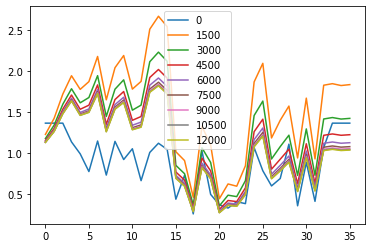

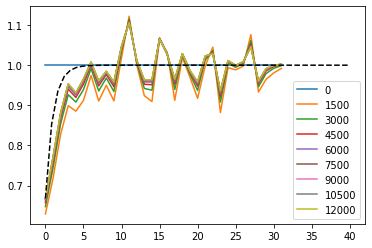

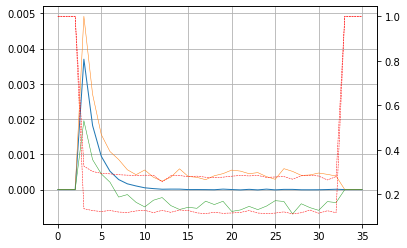

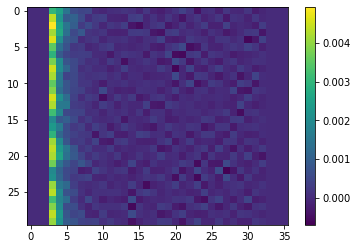

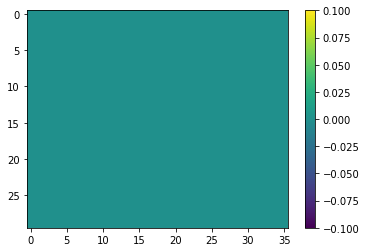

In [743]:

ut = list()
for i in range(0,time,int(time/10))[:-1]:
    print(i)
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['U'][0,2,2:-2,0]/Velocity, label=i)
    ut.append(np.absolute(f['U'][0,0,0,0]))
plt.legend()
    

plt.figure()
from scipy.integrate import odeint

def dydt(y,t,*gamma):
     return gamma[0]*(1-y)
   

y0 = f['PHI'][0,2,6]

t = np.linspace(0,40)
sol = odeint(dydt, y0, t, args=(LinearReactionRate/Velocity,0))


for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['PHI'][0,2,6:-2], label=i)
    
plt.plot(t,sol, 'k--', lw=1.5)

plt.legend()


plt.figure()

plt.plot(f['ReactiveFlux'][0,:,2:-2].mean(axis=0), '-', lw=1)
plt.plot(f['ReactiveFlux'][0,:,2:-2].max(axis=0), '-', lw=0.5)
plt.plot(f['ReactiveFlux'][0,:,2:-2].min(axis=0), '-', lw=0.5)

plt.grid()
plt.twinx()
plt.plot(f['Porosity'][0,:,2:-2].min(axis=0), 'r--', lw=0.5)
plt.plot(f['Porosity'][0,:,2:-2].max(axis=0), 'r--', lw=0.5)

plt.figure()

plt.imshow(f['ReactiveFlux'][0,:,2:-2] )
plt.colorbar()

plt.figure()
C = 4*Porosity[:,2:-2]*(1-Porosity[:,2:-2])*LinearReactionRate*(1 - f['PHI'][0,:,2:-2]);
plt.imshow(C*SolidFluidReactionRate > Porosity[:,2:-2])
plt.colorbar()

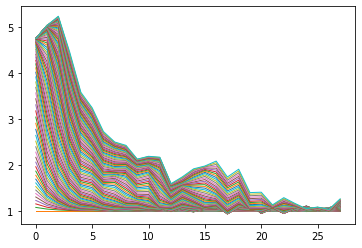

In [745]:
plt.figure()
i = time
f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)  

for i in time+np.arange(0,time1,int(time1/(makroIterations)))[:]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    #plt.plot(f['Porosity'][0,:,6:-6].min(axis=0), '--', lw=0.5)
    #plt.plot(f['Porosity'][0,:,6:-6].max(axis=0), '--', lw=0.5)
    plt.plot((f['Porosity'][0,:,6:-6]/f0['Porosity'][0,:,6:-6]).mean(axis=0), '-', lw=1)

/tmp/ipykernel_8017/1650754929.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

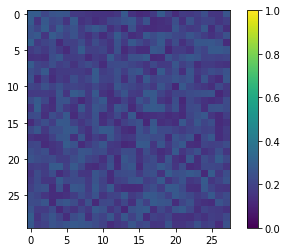

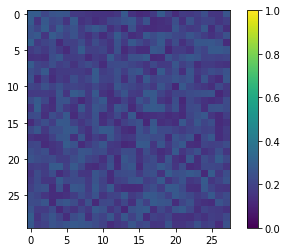

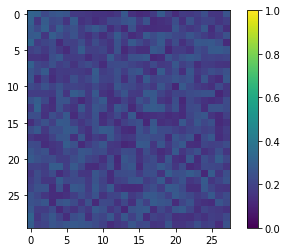

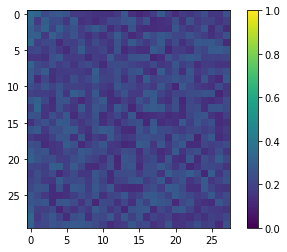

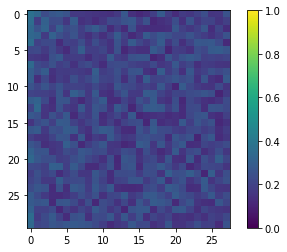

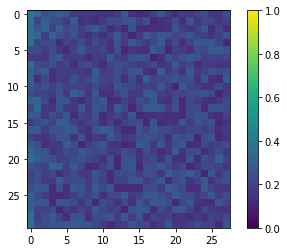

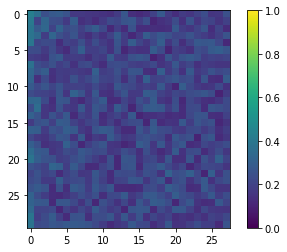

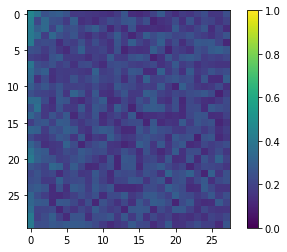

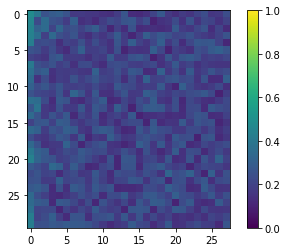

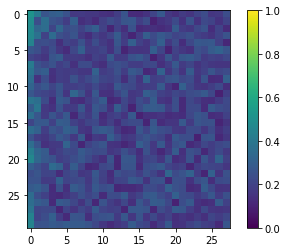

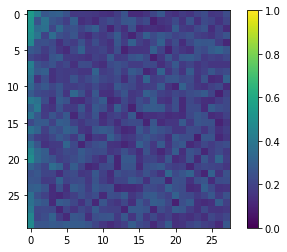

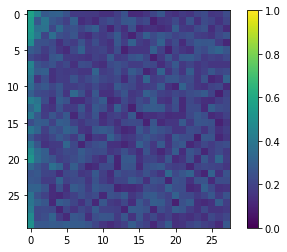

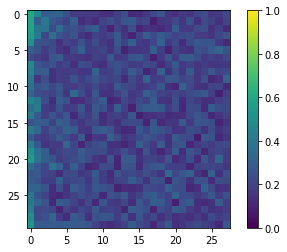

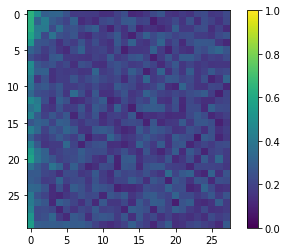

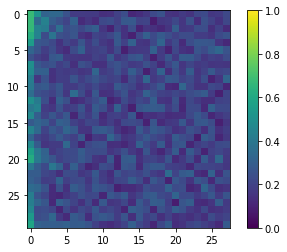

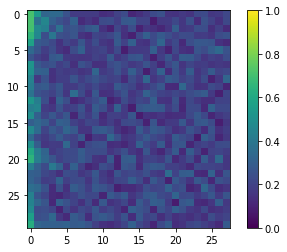

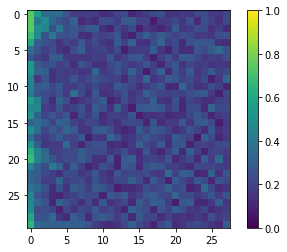

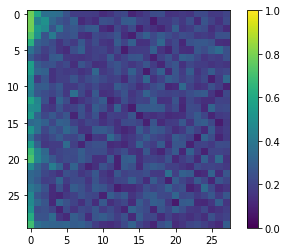

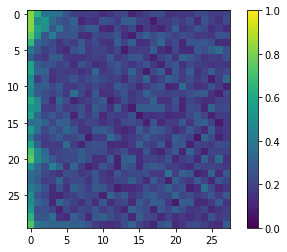

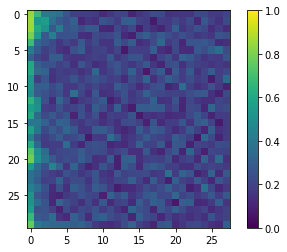

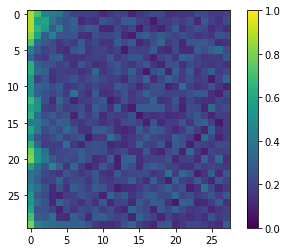

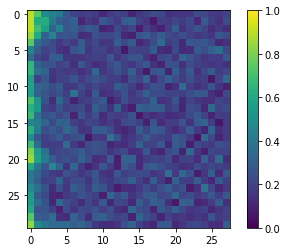

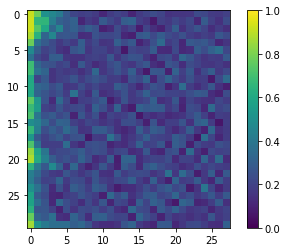

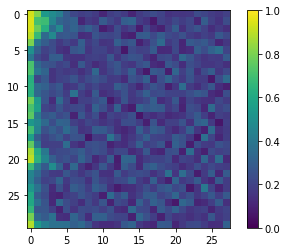

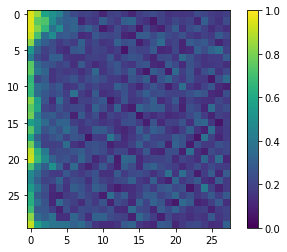

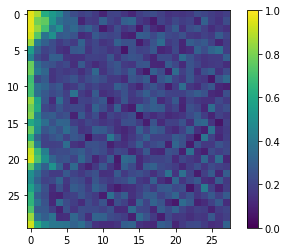

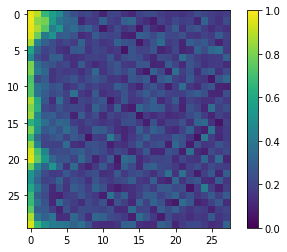

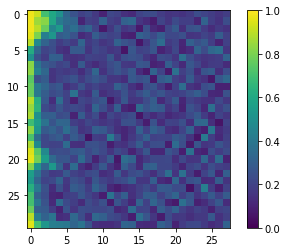

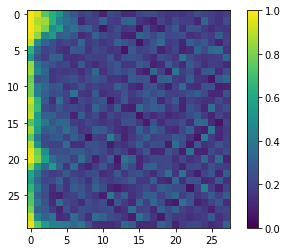

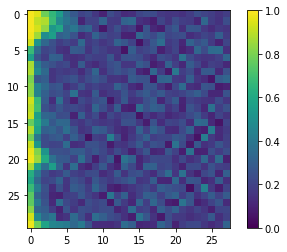

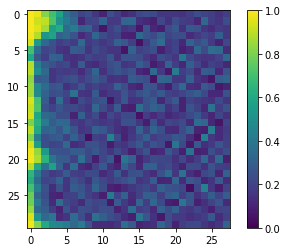

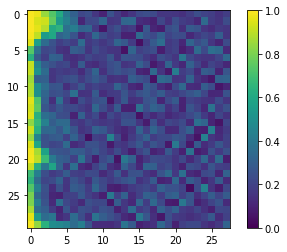

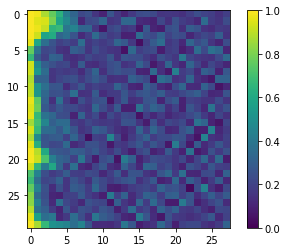

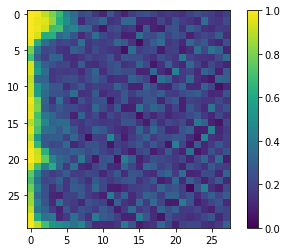

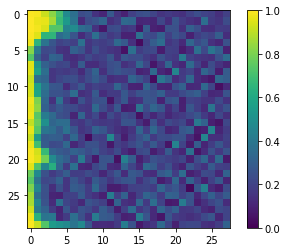

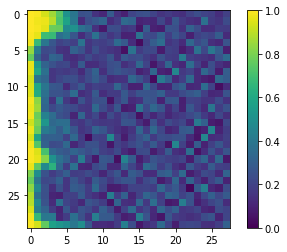

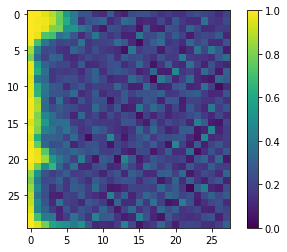

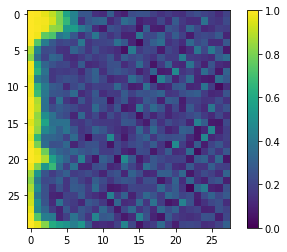

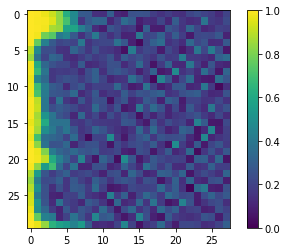

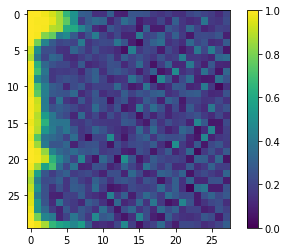

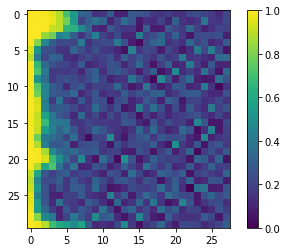

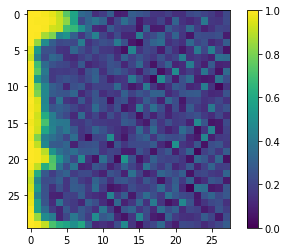

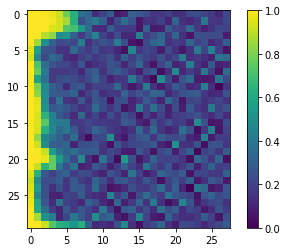

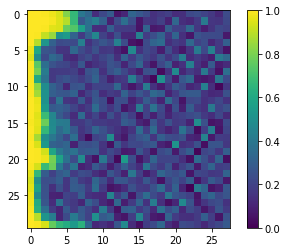

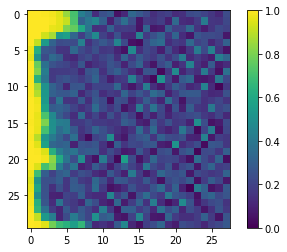

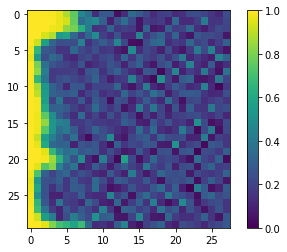

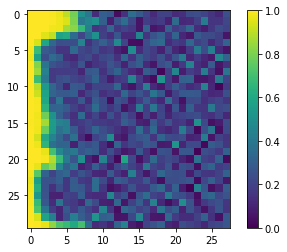

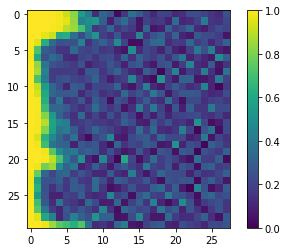

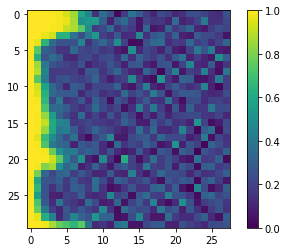

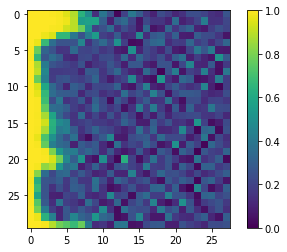

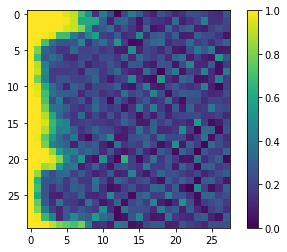

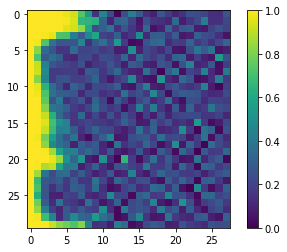

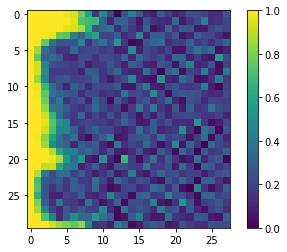

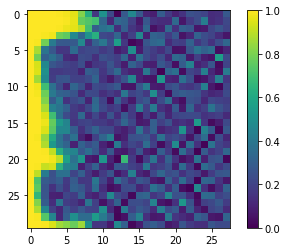

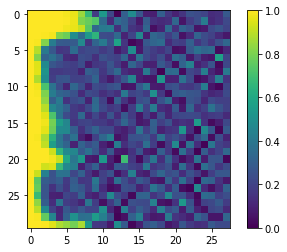

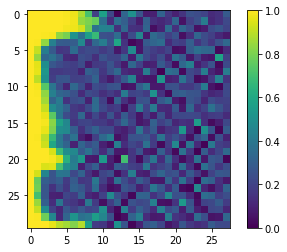

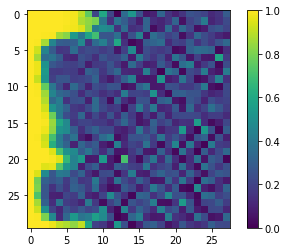

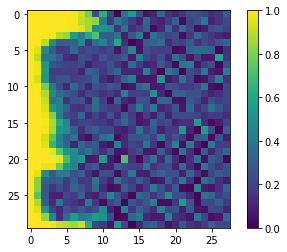

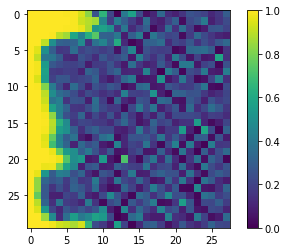

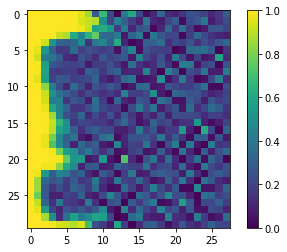

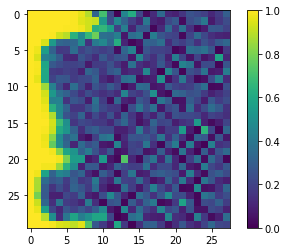

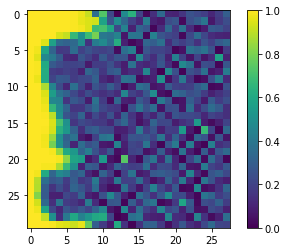

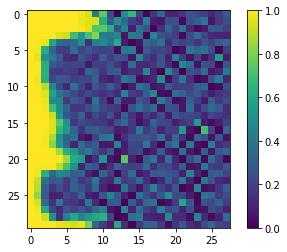

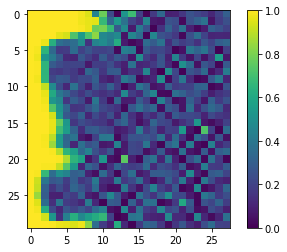

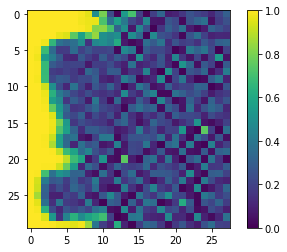

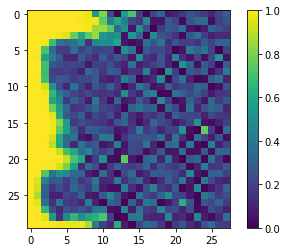

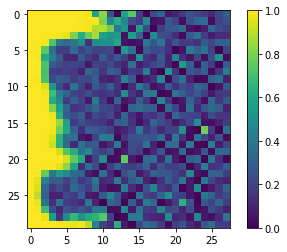

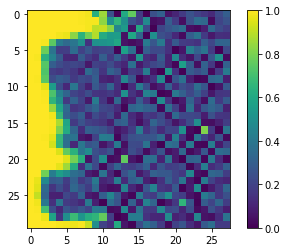

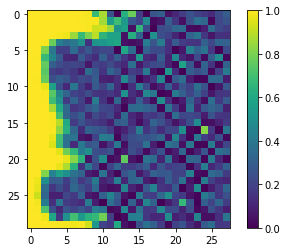

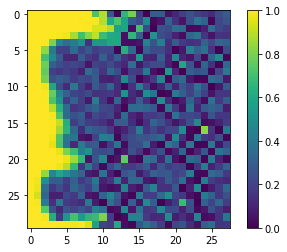

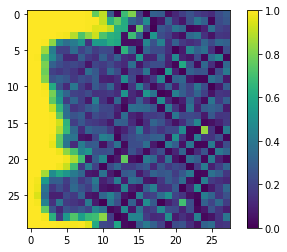

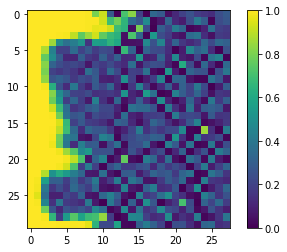

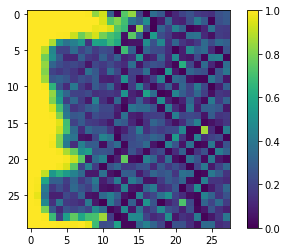

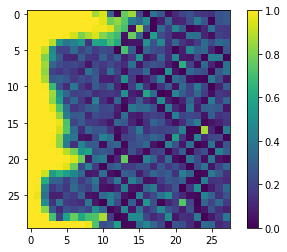

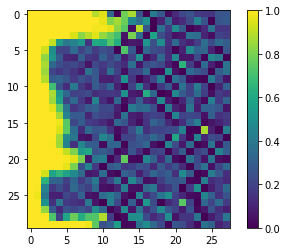

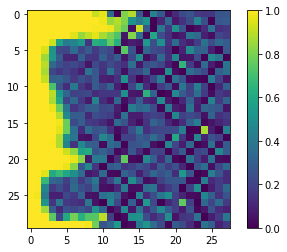

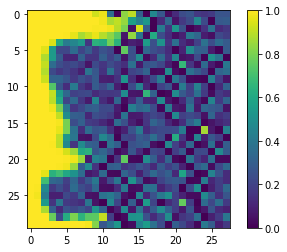

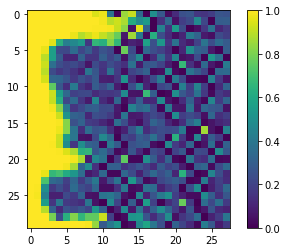

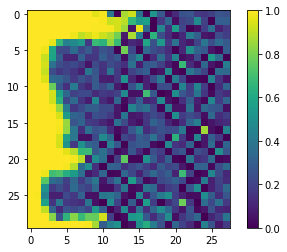

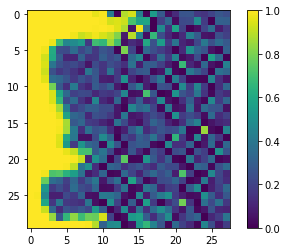

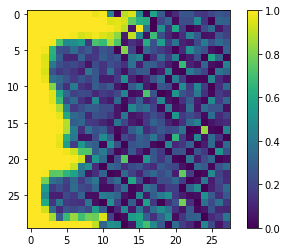

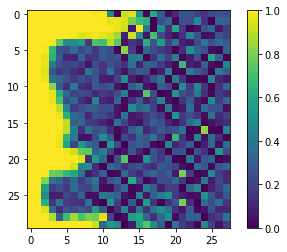

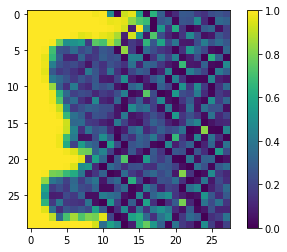

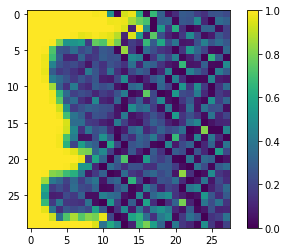

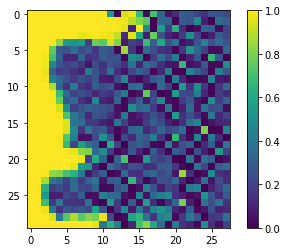

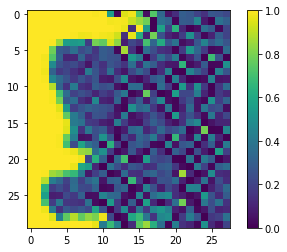

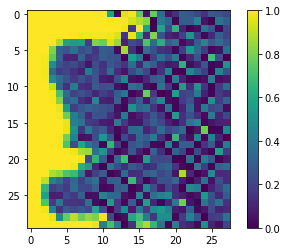

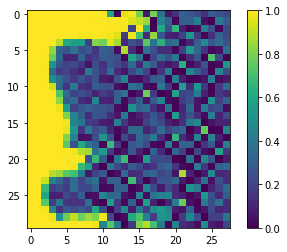

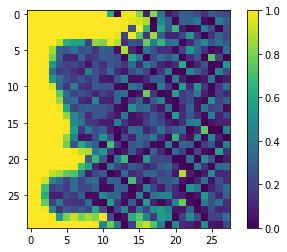

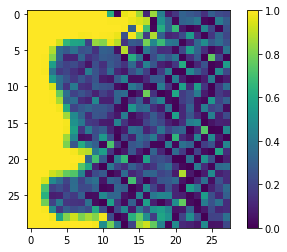

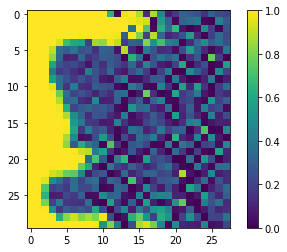

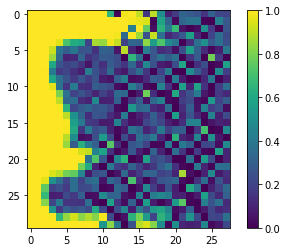

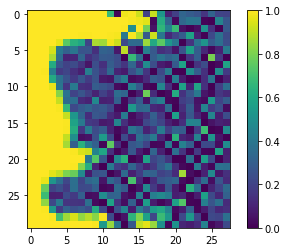

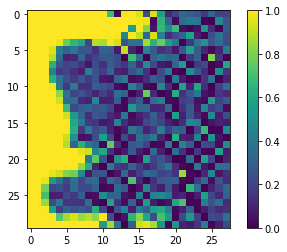

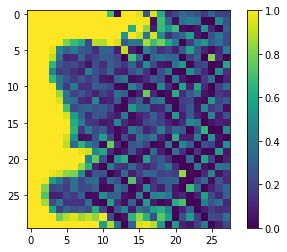

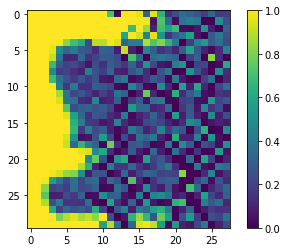

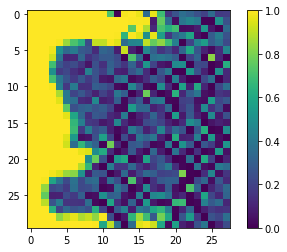

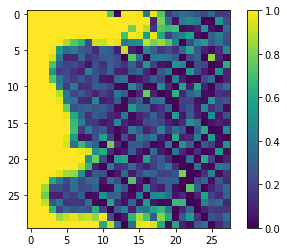

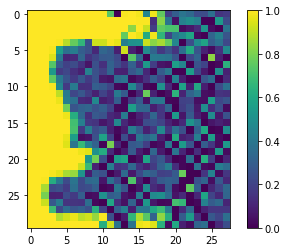

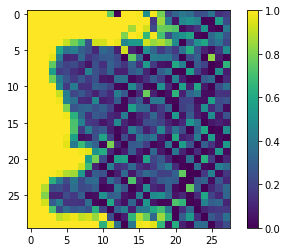

In [753]:
plt.figure()
i = time
f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)  
ii = 1
for i in time+np.arange(0,time1,int(time1/(makroIterations)))[:]:
    plt.figure()
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    df = f['Porosity'][0,:,6:-6]#/f0['Porosity'][0,:,6:-6] 
    plt.imshow(df,interpolation='none')
    plt.clim(0,1)
    plt.colorbar()
    ii = ii + 1
    plt.savefig(r'./movie/wormhole-%03d.png'%ii, dpi=100)